# Analysis of intrinsic results: GeoDanmark

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle
import json
import pandas as pd
import seaborn as sns
import plotly.express as px
import h3

%run ../settings/yaml_variables.py
%run ../settings/df_styler.py
%run ../settings/plotting.py
%run ../settings/load_refdata.py

<string>:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
/Users/anev/Library/CloudStorage/Dropbox/ITU/repositories/bikedna_dk_analysis/settings/plotting.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name, n)


Reference data loaded successfully!


In [3]:
# Read intrinsic grid results
with open(
    f"../results/REFERENCE/{study_area}/data/grid_results_intrinsic.pickle", "rb"
) as fp:
    ref_intrinsic_grid = pickle.load(fp)

# Import intrinsic results
ref_intrinsic_file = open(
    f"../results/REFERENCE/{study_area}/data/intrinsic_analysis.json"
)

ref_intrinsic_results = json.load(ref_intrinsic_file)

# Import summary dataframe
summarize_results_df = pd.read_csv(f"../results/REFERENCE/{study_area}/data/intrinsic_summary_results.csv",index_col=0)

summarize_results_df.style.pipe(format_ref_style)

,
Total infrastructure length (km),"8,676"
Protected bicycle infrastructure density (m/km2),92
Unprotected bicycle infrastructure density (m/km2),95
Mixed protection bicycle infrastructure density (m/km2),0
Bicycle infrastructure density (m/km2),187
Nodes,"51,224"
Dangling nodes,"11,218"
Nodes per km2,1
Dangling nodes per km2,0
Overshoots,99


## Municipal Analysis

In [4]:
# Read muni data
muni = gpd.read_file("../data/municipalities.gpkg")
muni = muni[['navn','kommunekode','geometry']]
assert muni.crs == study_crs

**Assign municipal ID/name to all grid cells**

In [5]:
# Assign municipal name and id to each hex cell based on centroid overlap
ref_intrinsic_grid.dropna(subset='count_ref_edges',inplace=True)

grid_centroids = ref_intrinsic_grid[['geometry','grid_id','count_ref_edges']].copy()
grid_centroids['geometry'] = grid_centroids.geometry.centroid

centroid_join = grid_centroids.sjoin(muni, predicate="intersects", how="inner")
centroid_join.drop('index_right',axis=1,inplace=True)

non_joined_centroid = grid_centroids[grid_centroids.count_ref_edges.notna() & ~grid_centroids.grid_id.isin(centroid_join.grid_id)] #drop(['navn','kommunekode'],axis=1)

centroid_join_2 = non_joined_centroid.sjoin_nearest(muni, how="left",distance_col='dist')

assert len(centroid_join_2) + len(centroid_join) == len(ref_intrinsic_grid)

joined_int_grid = pd.concat([centroid_join_2,centroid_join])

assert len(joined_int_grid) == len(ref_intrinsic_grid)

int_grid = ref_intrinsic_grid.merge(joined_int_grid[['grid_id','navn','kommunekode']],left_on='grid_id',right_on='grid_id')
assert len(int_grid) == len(ref_intrinsic_grid)

**Index nodes and edges by municipality**

In [6]:
# Index nodes and edges by municipality
muni_edges = ref_edges_simplified.sjoin(muni,how="left",predicate="intersects")
muni_edges.drop('index_right',axis=1,inplace=True)

nodes_joined = gpd.sjoin(muni, ref_nodes_simplified, how="right",predicate="contains")
nodes_joined.drop('index_left',axis=1,inplace=True)

nodes_joined_2 = gpd.sjoin_nearest(muni, nodes_joined[nodes_joined.navn.isna()][['nodeID','x','y','geometry']], how='right', distance_col="dist")
nodes_joined_2.drop('index_left',axis=1,inplace=True)
nodes_joined_2.drop_duplicates(subset='nodeID', keep="first",inplace=True)

nodes_joined.dropna(subset='navn',inplace=True)

muni_nodes = pd.concat([nodes_joined,nodes_joined_2])

assert len(muni_nodes) == len(ref_nodes_simplified)
assert len(muni_nodes) == len(muni_nodes.nodeID.unique())
assert len(muni_nodes[muni_nodes.navn.isna()]) == 0
assert len(muni_edges[muni_edges.navn.isna()]) == 0

# Recompute length - for GeoDK, infra length is equal to geom length
muni_edges['infrastructure_length'] = muni_edges.geometry.length

# Index dangling nodes by muni
dang_joined = gpd.sjoin(muni, ref_dangling, how="right",predicate="contains")
dang_joined.drop('index_left',axis=1,inplace=True)

dang_joined_2 = gpd.sjoin_nearest(muni, dang_joined[dang_joined.navn.isna()][['nodeID','x','y','geometry']], how='right', distance_col="dist")
dang_joined_2.drop('index_left',axis=1,inplace=True)

dang_joined_2.drop_duplicates(subset='nodeID', keep="first",inplace=True)

dang_joined.dropna(subset='navn',inplace=True)

muni_dang = pd.concat([dang_joined,dang_joined_2])

assert len(muni_dang) == len(ref_dangling)
assert len(muni_dang) == len(muni_dang.nodeID.unique())
assert len(muni_dang[muni_dang.navn.isna()]) == 0
assert len(muni_dang[muni_dang.navn.isna()]) == 0

# Group by muni
grouped_edges = muni_edges.groupby("navn") 
grouped_nodes = muni_nodes.groupby("navn")
grouped_dangling = muni_dang.groupby("navn")

# Turn into dataframe
muni_infra = grouped_edges['infrastructure_length'].sum().to_frame()

muni_node_count = grouped_nodes.size().to_frame('node_count') 

muni_dang_count = grouped_dangling.size().to_frame('dangling_node_count') 

muni_network_counts = pd.merge(pd.merge(muni_infra, muni_node_count,left_index=True, right_index=True),muni_dang_count,left_index=True, right_index=True)

assert len(muni_network_counts) == 98


**Plot length of bicycle infrastructure, bicycle infrastructure density and infrastructure per 1000 people**

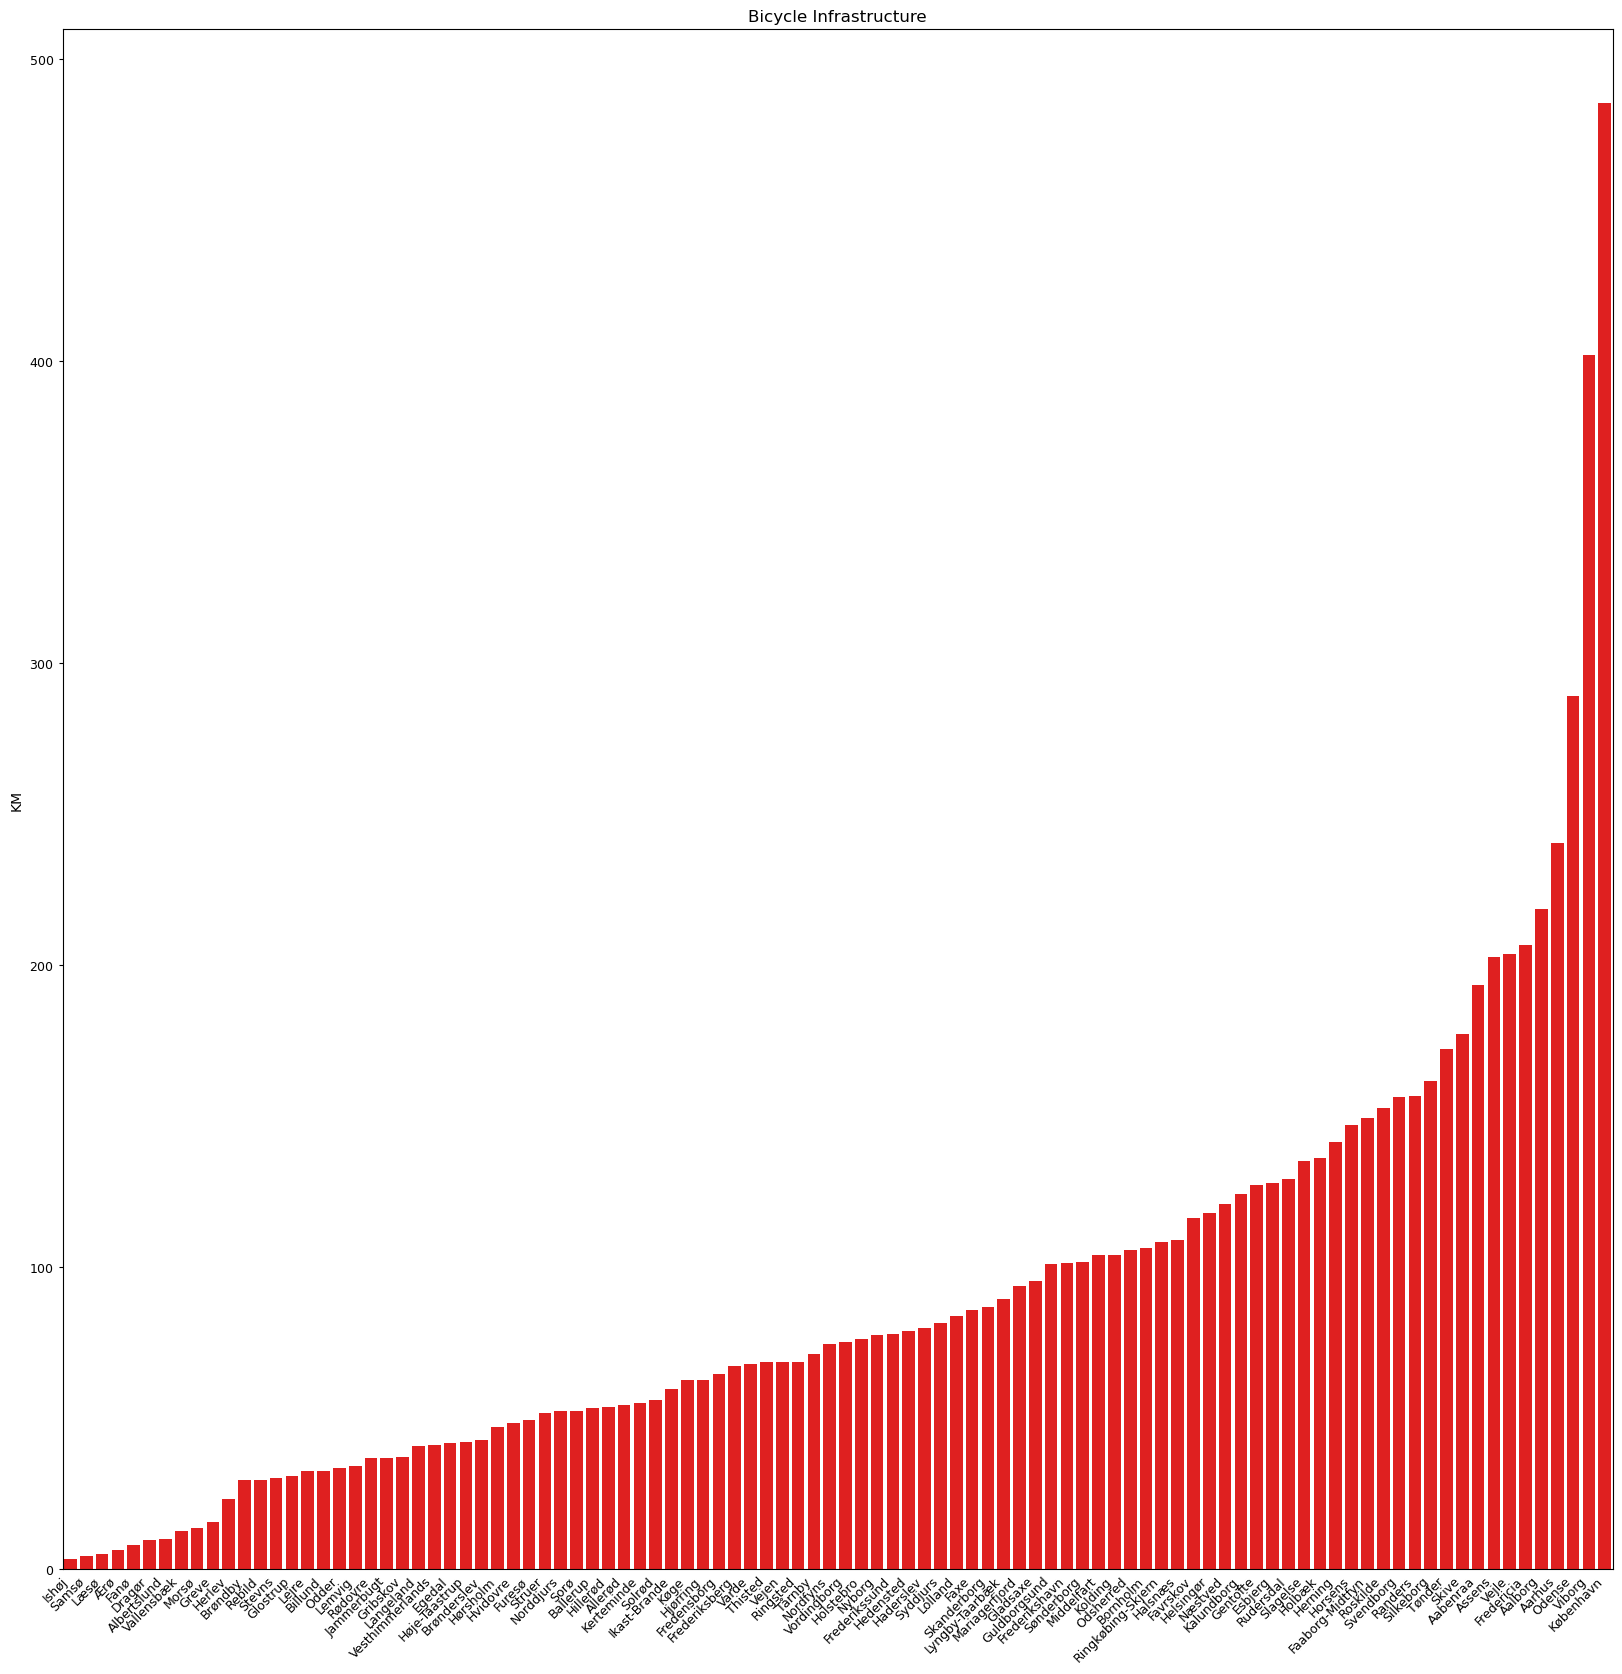

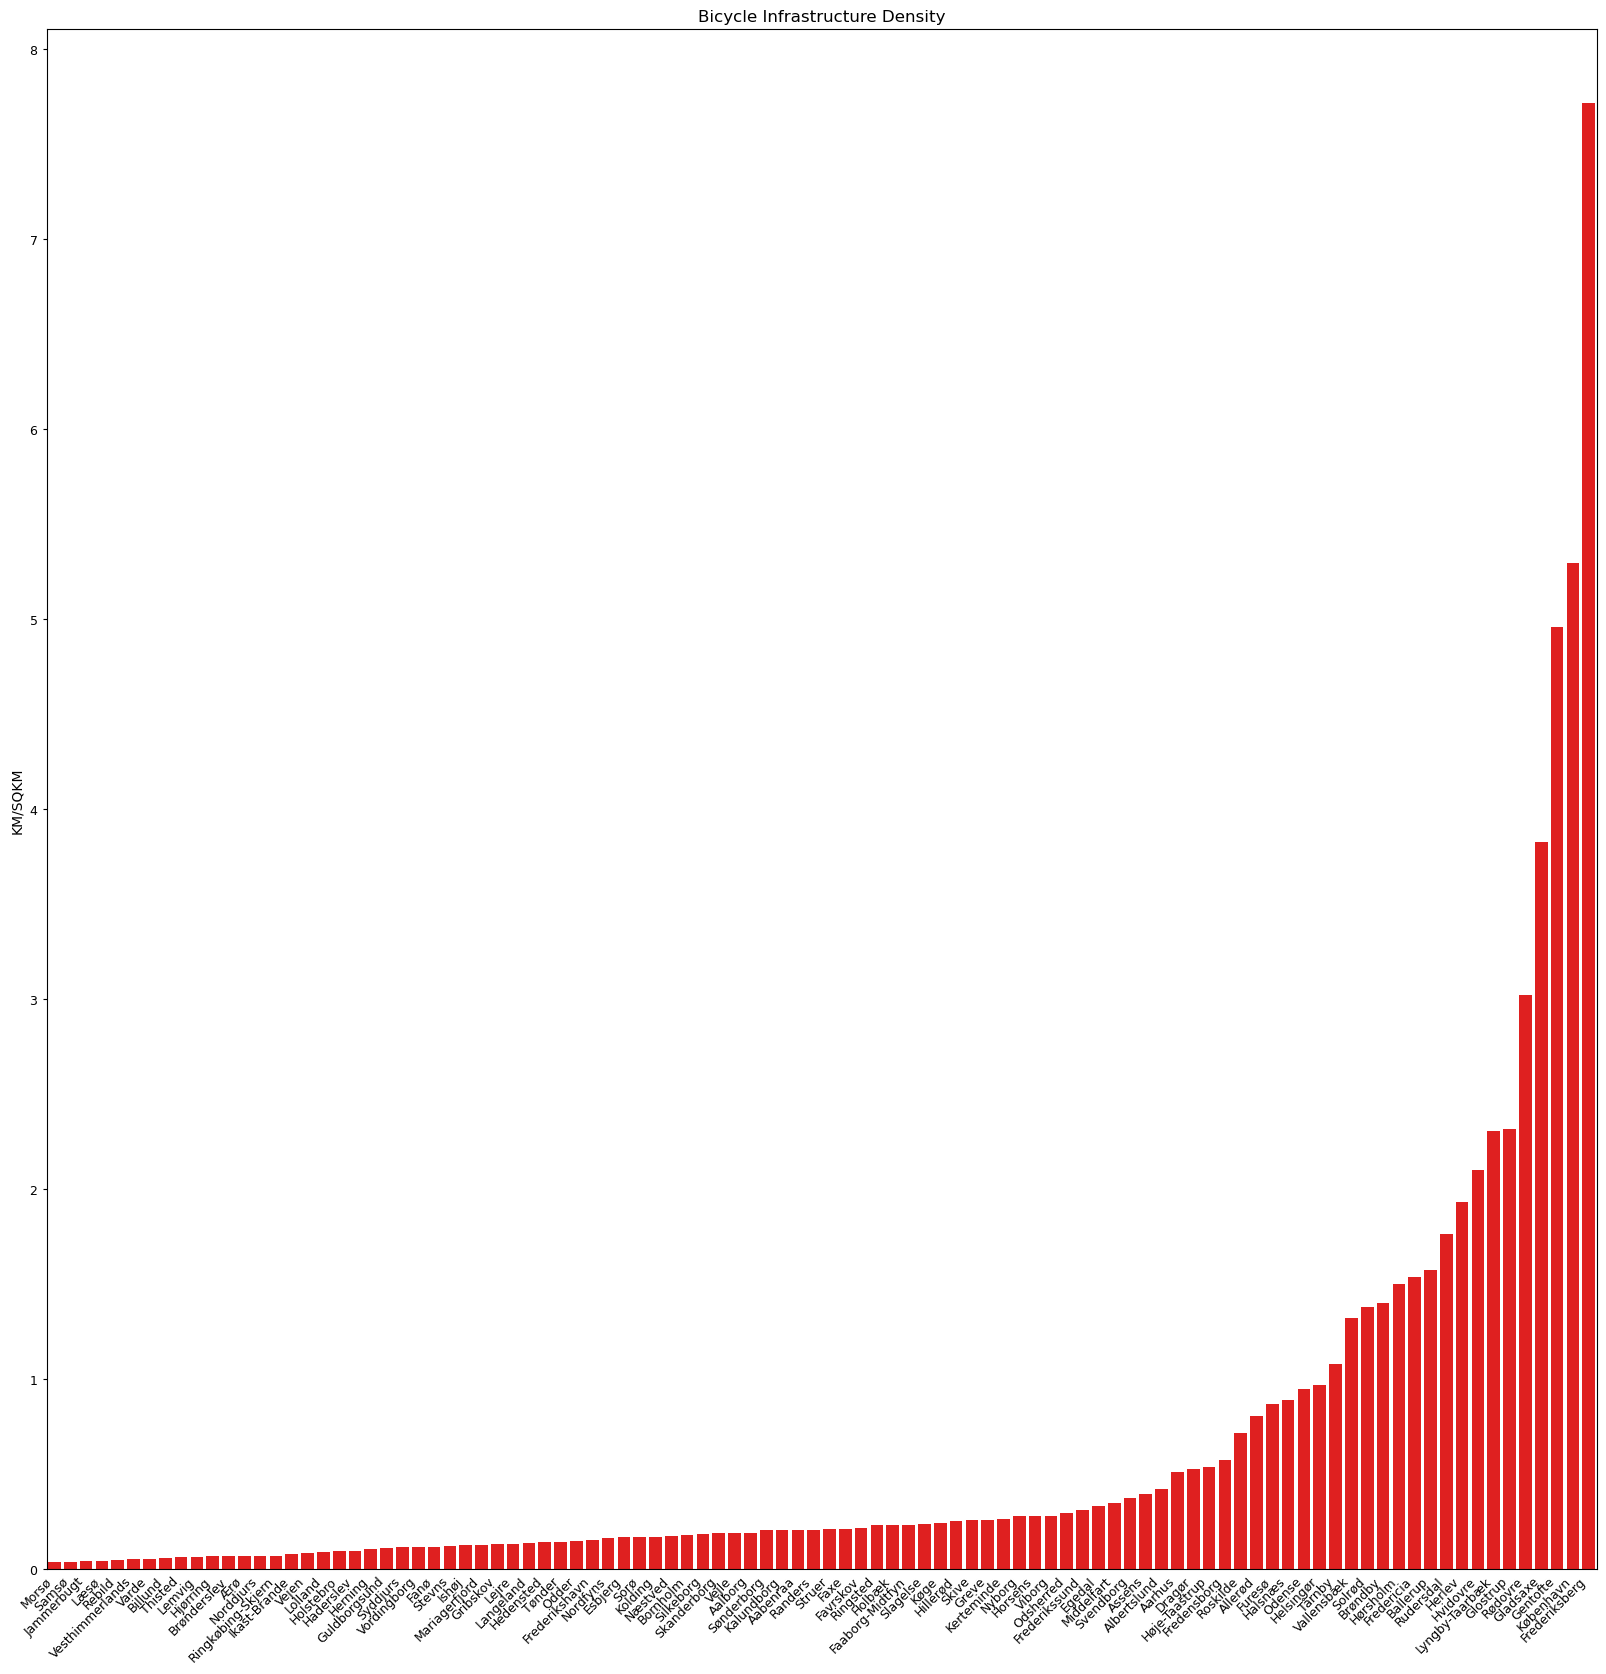

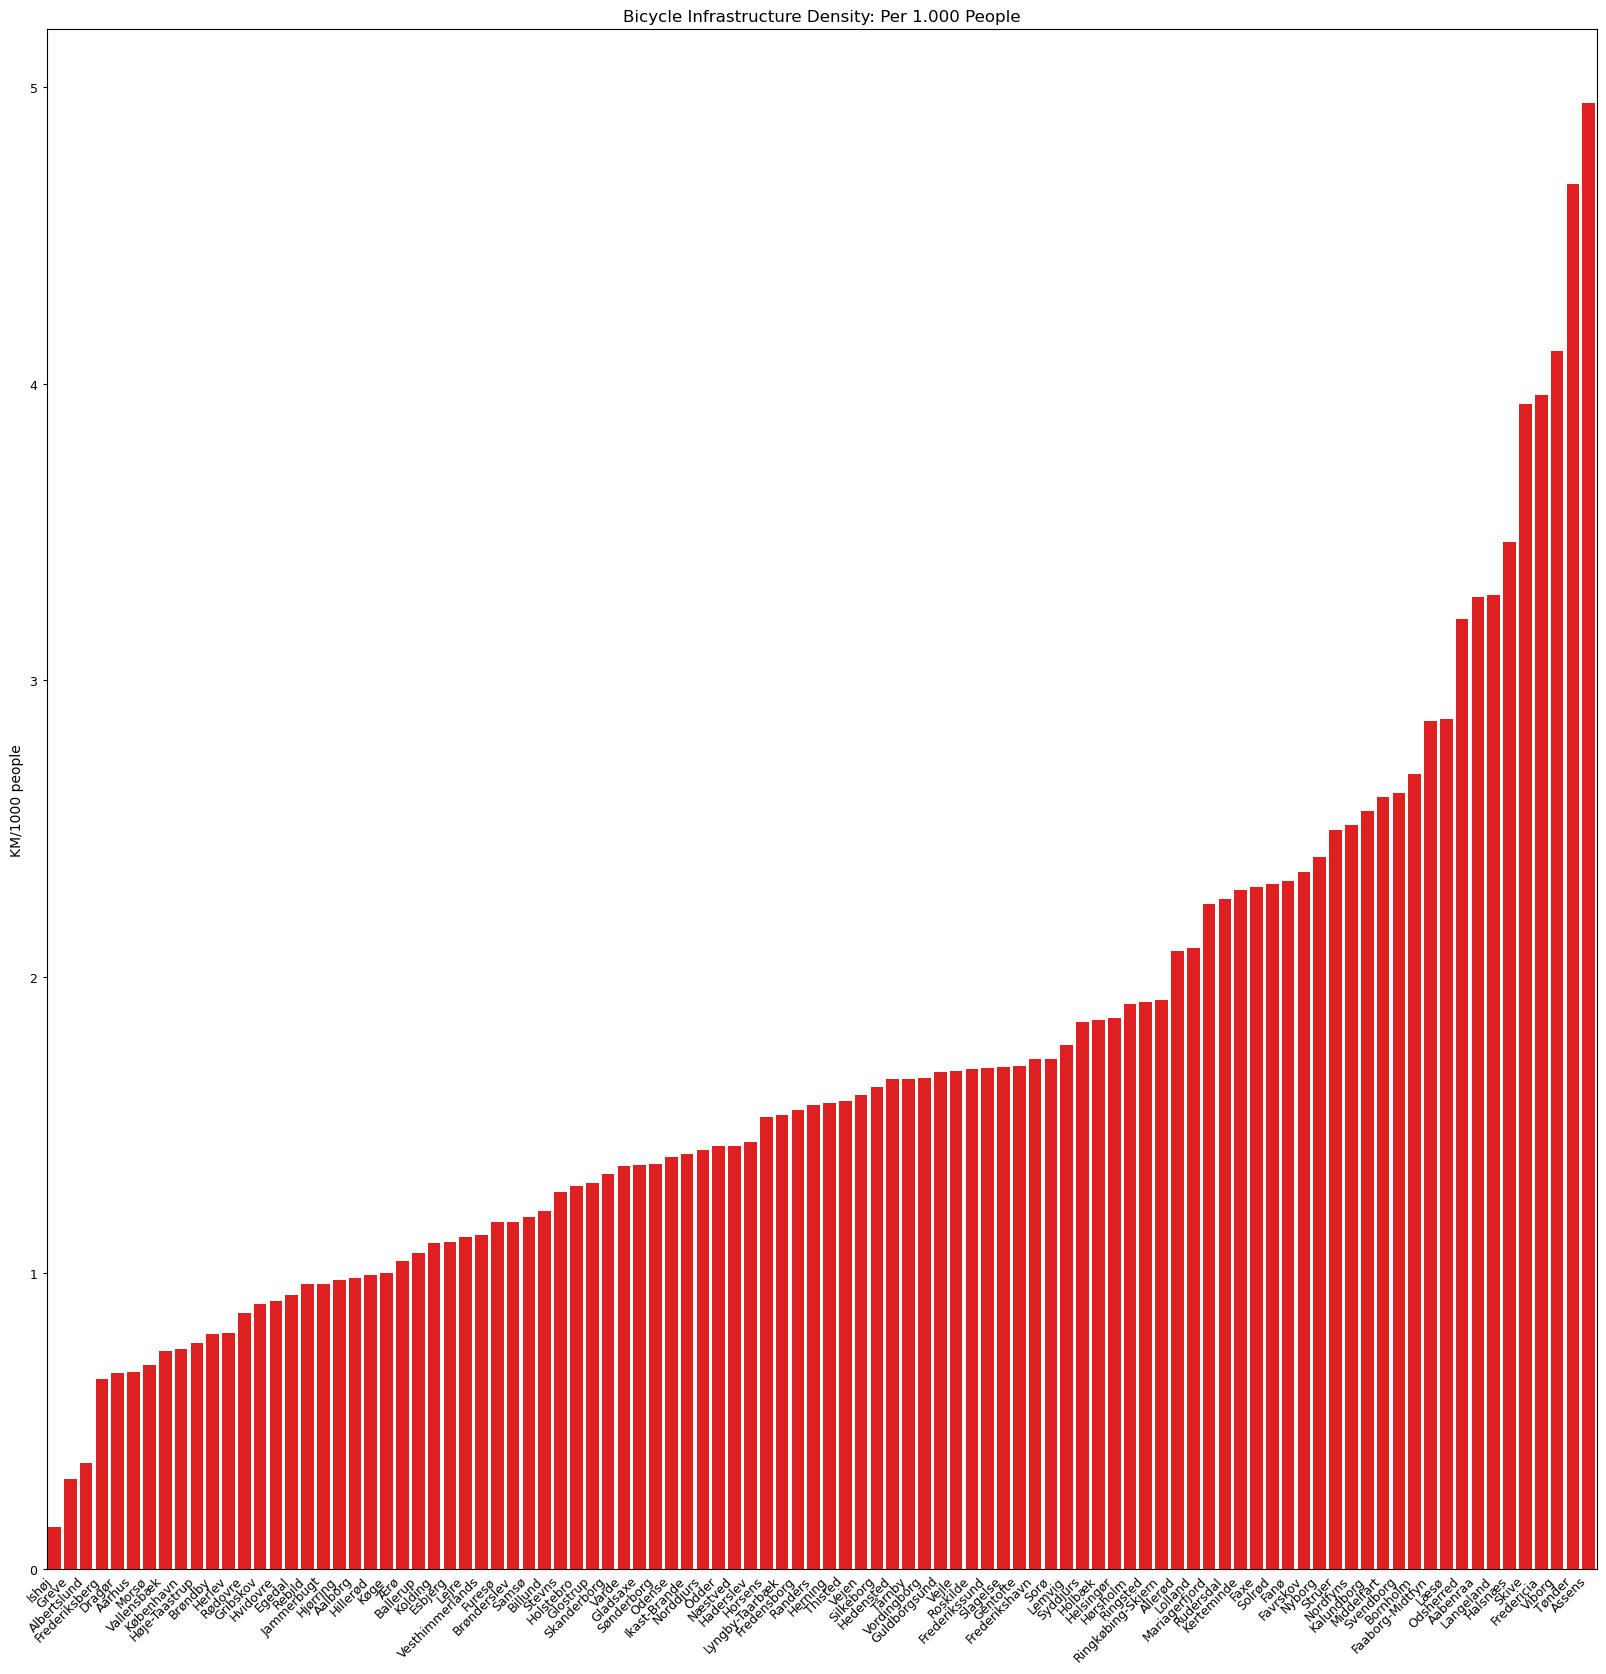

In [7]:
# Plot km of bicycle infra per muni
muni_network_counts['infra_km'] = round(muni_network_counts.infrastructure_length / 1000,3)

fig, ax = plt.subplots(figsize=(20,20))
sns.barplot(muni_network_counts.reset_index().sort_values('infra_km'), x="navn",y='infra_km',ax=ax, color='red')
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel('')
plt.ylabel('KM')
plt.title('Bicycle Infrastructure');

# Plot infra density per muni
muni['area_sqkm'] = round(muni.area / 1000000,2)

muni_network_counts = muni_network_counts.merge(
    muni[['navn','area_sqkm']],left_index=True,right_on='navn'
)

muni_network_counts['infra_dens'] = round(muni_network_counts.infra_km / muni_network_counts.area_sqkm,3)

fig, ax = plt.subplots(figsize=(20,20))
sns.barplot(muni_network_counts.reset_index().sort_values('infra_dens'), x="navn",y='infra_dens',ax=ax, color='red')
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel('')
plt.ylabel('KM/SQKM')
plt.title('Bicycle Infrastructure Density');

# Plot infra per pop
muni_pop = pd.read_csv("../data/muni_pop.csv",encoding="ISO-8859-1",header=None)
muni_pop.rename({1:'navn',2:'pop'},inplace=True,axis=1)

muni_network_counts = muni_network_counts.merge(muni_pop[['navn','pop']],left_on='navn', right_on='navn')
assert len(muni_network_counts) == 98

muni_network_counts['infra_pop'] = muni_network_counts.infra_km / (muni_network_counts['pop'] / 1000)

fig, ax = plt.subplots(figsize=(20,20))
sns.barplot(muni_network_counts.reset_index().sort_values('infra_pop'), x="navn",y='infra_pop',ax=ax, color='red')
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel('')
plt.ylabel('KM/1000 people')
plt.title('Bicycle Infrastructure Density: Per 1.000 People');

**Index over and undershoots by municipality**

In [8]:
# Join over and undershoot to muni
overshoot_edge_ids = pd.read_csv(ref_results_data_fp+"overshoot_edges_3.csv")
undershoot_node_ids = pd.read_csv(ref_results_data_fp+"undershoot_nodes_3.csv")

undershoots = ref_nodes_simplified[ref_nodes_simplified.nodeID.isin(undershoot_node_ids.node_id)]
assert len(undershoot_node_ids) == len(undershoots)

overshoots = ref_edges_simplified[ref_edges_simplified.edge_id.isin(overshoot_edge_ids.edge_id)]
assert len(overshoot_edge_ids) == len(overshoots)

# Join to muni
over_muni = overshoots[['edge_id','geometry']].sjoin(muni,how='left',predicate='intersects')

under_muni = undershoots[['nodeID','geometry']].sjoin(muni,how='left', predicate='intersects')

assert len(over_muni) == len(overshoots)
assert len(under_muni) == len(undershoots)

# Group by muni and count
over_df = over_muni.groupby('navn').size().to_frame('overshoots')

under_df = under_muni.groupby('navn').size().to_frame('undershoots')

# Combine with muni_network
muni_network_counts = pd.merge(muni_network_counts, over_df,left_on='navn', right_on='navn', how='left')
assert len(muni_network_counts) == 98

muni_network_counts = pd.merge(muni_network_counts, under_df,left_on='navn', right_on='navn', how='left')
assert len(muni_network_counts) == 98

muni_network_counts['over_under'] = muni_network_counts.overshoots + muni_network_counts.undershoots
muni_network_counts['over_under'].fillna(0,inplace=True)

**Join over and undershoots to grid cells**

In [9]:
# Join over and undershoots to grid ids
overshoots_grid = overshoots[['edge_id','geometry']].sjoin(int_grid,how='left').drop_duplicates(subset='edge_id',keep="first")[['grid_id']].reset_index(drop=True)
undershoots_grid = undershoots[['nodeID','geometry']].sjoin(int_grid,how='left').drop_duplicates(subset='nodeID',keep="first")[['grid_id']].reset_index(drop=True)

over_grid_grouped = overshoots_grid.groupby('grid_id').size().to_frame('overshoots_count')
under_grid_grouped = undershoots_grid.groupby('grid_id').size().to_frame('undershoots_count')

int_grid_org_len = len(int_grid)

int_grid = int_grid.merge(over_grid_grouped, left_on='grid_id',right_on='grid_id',how='left')
assert len(int_grid) == int_grid_org_len

int_grid = int_grid.merge(under_grid_grouped, left_on='grid_id',right_on='grid_id',how='left')
assert len(int_grid) == int_grid_org_len

int_grid['overshoots_count'].fillna(0,inplace=True)
int_grid['undershoots_count'].fillna(0,inplace=True)


**Join component gaps to municipality**

In [10]:
comp_gaps = gpd.read_file(ref_results_data_fp+"component_gaps_centroids_10.gpkg")
comp_gaps.head()

# Join to muni
gaps_muni = comp_gaps.sjoin(muni,how='left',predicate='intersects')

assert len(gaps_muni) == len(comp_gaps)

# Group by muni and count
gaps_df = gaps_muni.groupby('navn').size().to_frame('component_gaps')

# Combine with muni_network
muni_network_counts = pd.merge(muni_network_counts, gaps_df,left_on='navn', right_on='navn', how='left')
assert len(muni_network_counts) == 98

muni_network_counts['component_gaps'] = muni_network_counts.component_gaps.fillna(0).astype(int)

**Join component gaps to grid cells**

In [11]:
comp_gaps['gap_id'] = comp_gaps.index

gaps_grid = comp_gaps[['gap_id','geometry']].sjoin(int_grid,how='left').drop_duplicates(subset='gap_id',keep="first")[['grid_id']].reset_index(drop=True)
assert len(gaps_grid) == len(comp_gaps)

gaps_grouped = gaps_grid.groupby('grid_id').size().to_frame('component_gaps')

int_grid_org_len = len(int_grid)

int_grid = int_grid.merge(gaps_grouped, left_on='grid_id',right_on='grid_id',how='left')
assert len(int_grid) == int_grid_org_len

int_grid['component_gaps'] = int_grid['component_gaps'].fillna(0).astype(int)

**Correlation between infrastructure length and topology errors**

In [12]:
# TODO: Add label for high/low density and add as color?
fig = px.scatter(
    muni_network_counts, 
    x='infra_km', 
    y='component_gaps',
    title='Correlation between infrastructure length and component gaps', 
    hover_data=['navn'],
    labels={
        "infra_km": "Length of bicycle infrastructure (KM)",
        "component_gaps": "Gaps between disconnected components",
        "navn": "Municipality"
        })

fig.update_layout(
    font=dict(
        size=10,
        color="RebeccaPurple"
    )
)
fig.show()


# TODO: Add label for high/low density and add as color?
fig = px.scatter(
    muni_network_counts, 
    x='infra_km', 
    y='over_under',
    title='Correlation between infrastructure length and topology errors', 
    hover_data=['navn'],
    labels={
        "infra_km": "Length of bicycle infrastructure (KM)",
        "over_under": "Over and undershoots",
        "navn": "Municipality"
        })

fig.update_layout(
    font=dict(
        size=10,
        color="RebeccaPurple"
    )
)
fig.show()


**Index components by municipality**

In [13]:
muni_grid = int_grid.groupby('navn')

muni_components = {}

for name, group in muni_grid:
    nested_list = group.component_ids_ref.to_list()
    flat_list = list(set([item for sublist in nested_list for item in sublist]))

    muni_components[name] = len(flat_list)

muni_comp_df = pd.DataFrame.from_dict(muni_components,orient='index',columns=['component_count']).reset_index().rename({'index':'navn'},axis=1)
assert len(muni_comp_df) == 98

muni_network_counts = muni_network_counts.merge(muni_comp_df, left_on='navn', right_on='navn', how='left')
assert len(muni_network_counts) == 98


**Export**

In [14]:
# Export
assert len(muni_network_counts) == 98
muni_network_counts.to_csv("../results/geodk_quality/muni_network_counts.csv", index=False)

int_grid.to_parquet("../results/geodk_quality/int_grid.parquet")

**Plot scatterplots of correlation between number of components and infrastructure length, area, and density**

In [15]:
# Plot correlation between infrastructure length and no of componentsß
fig = px.scatter(
    muni_network_counts, 
    x='infra_km', 
    y='component_count',
    title='Correlation between infrastructure length and number of components', 
    hover_data=['navn'],
    color="area_sqkm",
    color_continuous_scale='viridis_r',
    labels={
        "infra_km": "Length of bicycle infrastructure (km)",
        "component_count": "Number of disconnected components",
        "navn": "Municipality",
        "area_sqkm": "Size (sqkm)",
        })

fig.update_layout(
    font=dict(
        size=12,
        color="RebeccaPurple"
    )
)
fig.show()

# Plot correlation between municipality size and no of componentsß
fig = px.scatter(
    muni_network_counts, 
    x='area_sqkm', 
    y='component_count',
    color="infra_km",
    title='Correlation between municipality size and number of components', 
    hover_data=['navn'],
    color_continuous_scale='viridis_r',
    labels={
        "area_sqkm": "Size (sqkm)",
        "infra_km": "Length (km)",
        "component_count": "Number of disconnected components",
        "navn": "Municipality"
        })

fig.update_layout(
    font=dict(
        size=12,
        color="RebeccaPurple"
    )
)
fig.show()

# Plot correlation between density and number of components
fig = px.scatter(
    muni_network_counts, 
    x='infra_dens', 
    y='component_count',
    #color="infra_km",
    title='Correlation between infrastructure density and number of components', 
    hover_data=['navn'],
    #color_continuous_scale='viridis_r',
    labels={
        # "area_sqkm": "Size (sqkm)",
        # "infra_km": "Length (km)",
        "infra_dens": "Infrastructure density",
        "component_count": "Number of disconnected components",
        "navn": "Municipality"
        })

fig.update_layout(
    font=dict(
        size=12,
        color="RebeccaPurple"
    )
)
fig.show()


**Plot all over and undershoots**

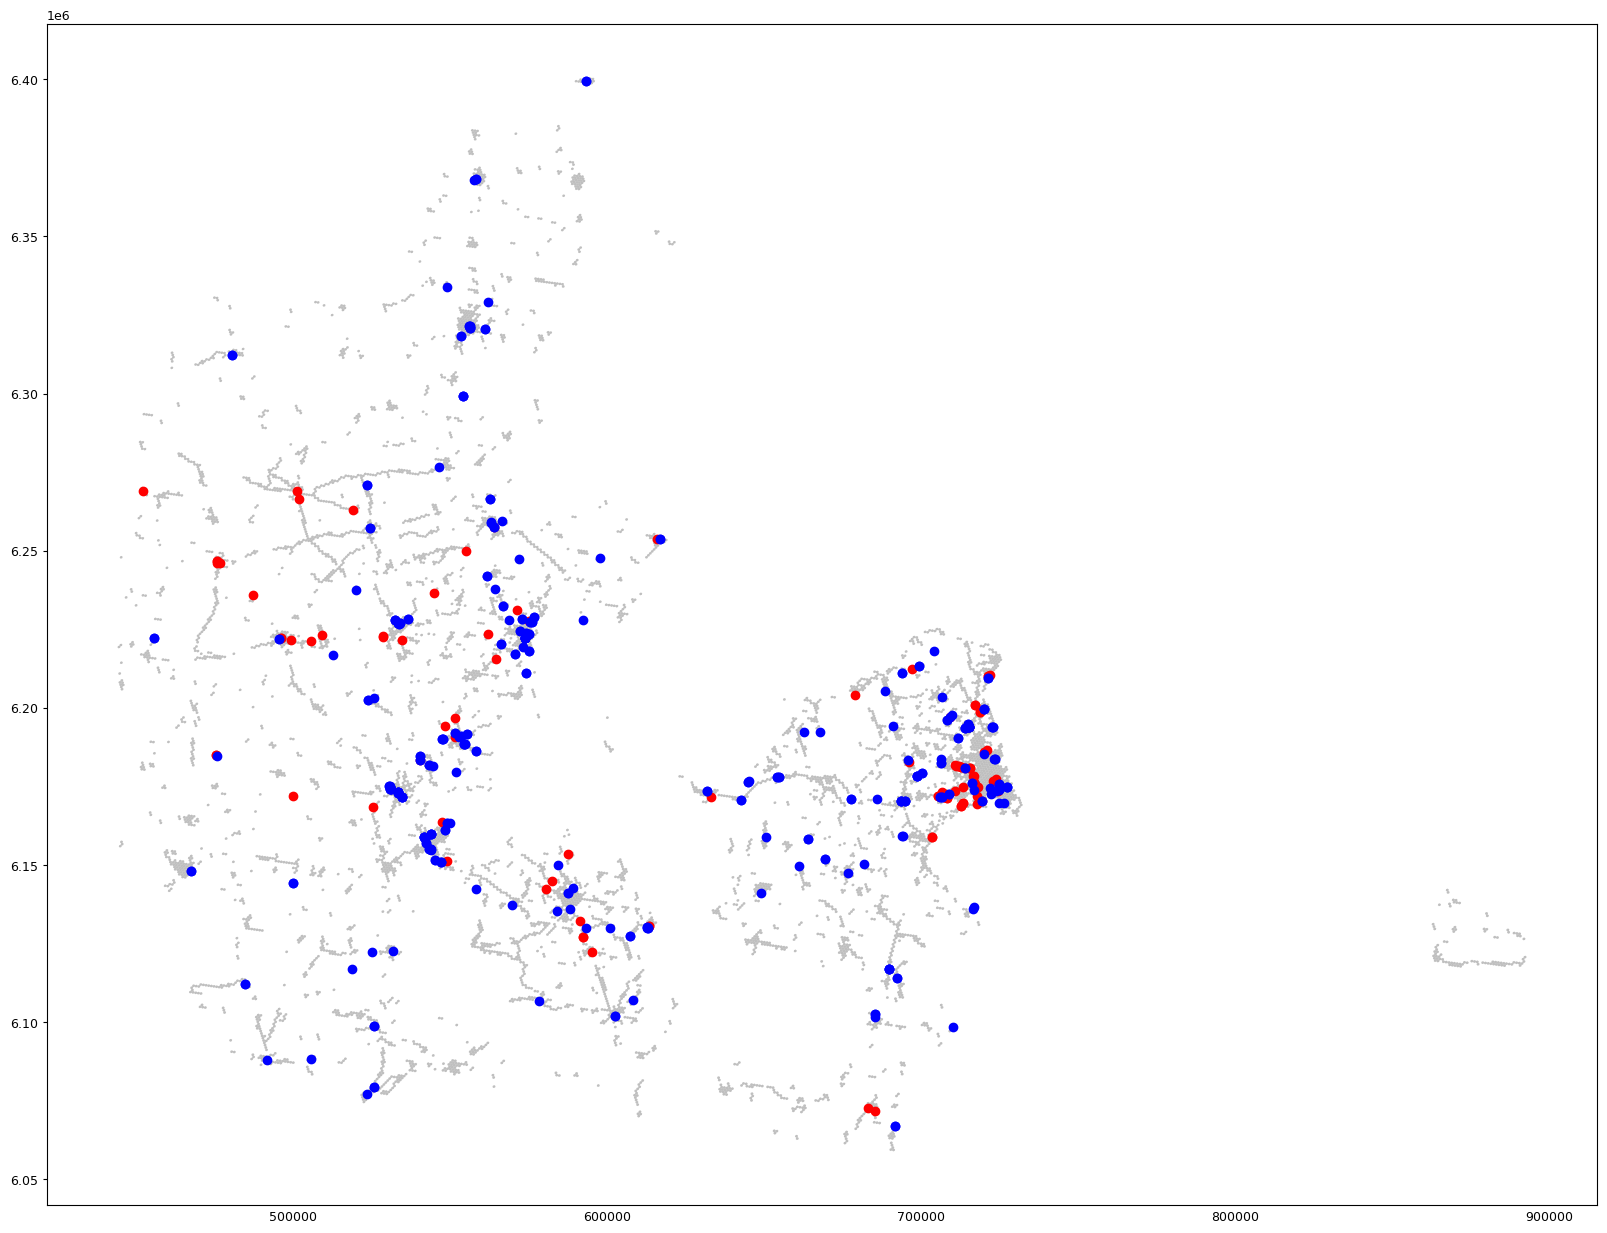

In [16]:
fig, ax = plt.subplots(figsize=(20,20))

int_grid.plot(ax=ax,alpha=0.5,color='grey')
overshoots_cent = overshoots.copy()
overshoots_cent['geometry'] = overshoots.centroid
overshoots_cent.plot(ax=ax,color='red')
undershoots.plot(ax=ax,color='blue');

## Spatial patterns in topology errors

- smooth density - quantify high dens
- smooth errors? - quanity high errors
- write down question?

Are there any areas with more topology errors than expected given the length/amount/density of infrastructure in the area?

1. Normalize number of topology errors with density
    1. For each grid cell: Get the km of bicycle infra in:
        - Distance band / K-rings
    2. Divide number of errors with km of infra value
2. Analyze patterns of normalized values



In [18]:
def radius_to_k_ring(input_dist, h3_res):

    '''
    input dist(numeric): desired distance in km

    returns number of k-rings for desired distance band
    '''

    ave_edge_length = h3.edge_length(h3_res)

    print('The average edge length is:', ave_edge_length)

    # One k-ring gives a distance band of approximately 2 edge lenghts
    # plus 1 edge length at the end for the final ring
    k = round((input_dist - ave_edge_length) / (2*ave_edge_length))

    final_dist = (k*2*ave_edge_length) + ave_edge_length
    print(f"The distance band will have a radius {final_dist:.2f} km")

    return k


def get_local_network_length(grid, density_col, area_col, hex_ids):

    """
    get the total network length in the surrounding hexs and the cell itself
    """

    total_dens = grid[grid.hex_id.isin(hex_ids)][density_col].mean() # meters per square KM
    
    area = grid[grid.hex_id.isin(hex_ids)][area_col].sum() #/ 1000000 # area should be provided in square km

    network_length = total_dens*area # in meters
    
    return network_length

In [147]:
hexid = int_grid.loc[0,'hex_id']

h3_res = h3.h3_get_resolution(hexid)
print("The hexagons are at resolution:", h3_res)

k = radius_to_k_ring(2, h3_res)

int_grid['k_rings'] = int_grid.apply(lambda x: h3.k_ring(x.hex_id, k),axis=1)

int_grid['area_sqkm'] = int_grid.area / 1000000

int_grid['local_length'] = int_grid.apply(lambda x: get_local_network_length(int_grid, 'ref_edge_density', 'area_sqkm', x.k_rings),axis=1)

The hexagons are at resolution: 8
The average edge length is: 0.461354684
The distance band will have a radius 2.31 km


In [148]:
def get_local_errors(grid, error_col, hex_ids):

    """
    get the count of errors in the surrouding hexs and the cell itself
    """

    total_errors = grid[grid.hex_id.isin(hex_ids)][error_col].sum() # 
    
    return total_errors

In [149]:
int_grid['local_overshoots'] = int_grid.apply(lambda x: get_local_errors(int_grid, 'undershoots_count', x.k_rings),axis=1)

## Alternative method:

- define spatial weight matrix using a distance band
- compute the spatial lag of errors
- compute the spatial lag of density
- Use this to compute density of errors

In [151]:
# import pysal libraries

# compute spatial weights

# visualise connectivity graph

# compute spatial lag - should this be standardized values? yes, row standardized - but also standardized before?

# look into spatial auto - 

,hex_id,geometry,grid_id,count_ref_edges,count_ref_nodes,count_ref_simplified_edges,count_ref_simplified_nodes,ref_edge_density,ref_node_density,ref_dangling_node_density,...,overshoots_count,undershoots_count,component_gaps,k_rings,area_sqkm,local_length,overshoot_dens,undershoot_dens,gap_dens,local_overshoots
0,881f224eb5fffff,"POLYGON ((546033.402 6158549.829, 545909.206 6...",881f224eb5fffff,212.0,205.0,23.0,16.0,3466.397650,26.788138,3.348517,...,0.0,0.0,0,"{881f224ea7fffff, 881f224ccbfffff, 881f224eabf...",0.597279,44395.360254,0.0,0.000000,0.000000,0.0
1,881f318c8bfffff,"POLYGON ((517765.714 6125537.630, 517640.452 6...",881f318c8bfffff,6.0,5.0,1.0,NaN,330.058587,0.000000,NaN,...,0.0,0.0,0,"{881f318c81fffff, 881f318cd5fffff, 881f318cddf...",0.599948,3013.211026,0.0,0.000000,0.000000,0.0
2,881f358583fffff,"POLYGON ((457012.464 6212323.290, 456886.468 6...",881f358583fffff,153.0,151.0,2.0,NaN,2791.736990,0.000000,NaN,...,0.0,0.0,0,"{881f35859dfffff, 881f3585bbfffff, 881f358599f...",0.583707,2289.013968,0.0,0.000000,0.000000,0.0
3,881f268d07fffff,"POLYGON ((491692.870 6294777.423, 491568.613 6...",881f268d07fffff,60.0,59.0,9.0,8.0,1065.547060,13.926965,5.222612,...,0.0,0.0,0,"{881f268d35fffff, 881f268d0dfffff, 881f268d29f...",0.574425,4532.971623,0.0,0.000000,0.000000,0.0
4,881f31b4b3fffff,"POLYGON ((558338.383 6142654.047, 558214.347 6...",881f31b4b3fffff,68.0,68.0,2.0,2.0,1659.124241,3.331480,3.331480,...,0.0,1.0,1,"{881f31b4b9fffff, 881f31b4b1fffff, 881f31b4bbf...",0.600334,3934.405083,0.0,0.254168,0.254168,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7408,881f2329a7fffff,"POLYGON ((709922.994 6190025.346, 709803.536 6...",881f2329a7fffff,235.0,230.0,10.0,5.0,3204.092320,8.280793,1.656159,...,0.0,0.0,0,"{881f2366d3fffff, 881f2329abfffff, 881f2329a1f...",0.603807,16077.344408,0.0,0.000000,0.000000,2.0
7409,881f05c2c1fffff,"POLYGON ((700959.512 6150745.426, 700839.353 6...",881f05c2c1fffff,245.0,243.0,9.0,7.0,3587.831898,11.498461,6.570549,...,0.0,0.0,0,"{881f05c289fffff, 881f05c2c3fffff, 881f05c2d5f...",0.608777,24967.757868,0.0,0.000000,0.000000,0.0
7410,881f058157fffff,"POLYGON ((724756.990 6172403.009, 724637.730 6...",881f058157fffff,181.0,174.0,15.0,8.0,4403.765930,13.173335,1.646667,...,0.0,0.0,0,"{881f058155fffff, 881f05815bfffff, 881f058143f...",0.607287,40643.625386,0.0,0.000000,0.000000,2.0
7411,881f0590e3fffff,"POLYGON ((722852.071 6185440.667, 722732.913 6...",881f0590e3fffff,194.0,189.0,17.0,12.0,4959.021463,19.824541,6.608180,...,0.0,0.0,0,"{881f0590e3fffff, 881f0590e7fffff, 881f0590e5f...",0.605310,47256.083447,0.0,0.000000,0.000000,3.0


In [140]:
int_grid['overshoot_dens'] = int_grid.overshoots_count / (int_grid.local_length / 1000)
int_grid['undershoot_dens'] = int_grid.undershoots_count / (int_grid.local_length / 1000)
int_grid['gap_dens'] = int_grid.component_gaps / (int_grid.local_length / 1000)

In [141]:
int_grid[['geometry','ref_edge_density','gap_dens']].to_file('../data/int_grid_4.gpkg')